In [5]:
# Import Packages
import numpy as np
import pandas as pd
import time
import warnings
from random import randint
from concurrent.futures import ProcessPoolExecutor
import concurrent
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as wgt
import tableMakerv2 as tm2
from Archive import tableMaker as tableMaker
import multiprocessing as mp

# Reimport changes when editing LiuInt or tableMaker
import importlib
importlib.reload(tm2)

<module 'tableMakerv2' from '/Users/cougar/jaredporter/inferno/codes/TableMakerMain/postGit/tableMakerv2.py'>

# tm2 Testing

## Generate tables

### Old Code - Serial

In [44]:
# OLD CODE: tableMaker
# NOTE: "OS" = 'old, Serial'

start = time.time()

numXim = 5
numXiv = 5
path = r"./aPriori/TNF"
Lvals = [0.00135, 0.0014, 0.0016, 0.002, 0.004, 0.006, 0.008, 0.02, 0.04, 0.2]
tvals = np.arange(0,11,1)

data_output_old = tableMaker.get_data_files(path, Lvals, tvals)

#----- Create T Table
table_OS, indices_OS = tableMaker.makeLookupTable(path, Lvals, tvals, phi='T',
                                    numXim = numXim, numXiv = numXiv, 
                                    get_data_files_output = data_output_old)
h_table_OS, h_indices_OS = tableMaker.makeLookupTable(path, Lvals, tvals, phi='h',
                                    numXim = numXim, numXiv = numXiv, 
                                    get_data_files_output = data_output_old)
c_table_OS, c_indices_OS = tableMaker.makeLookupTable(path, Lvals, tvals, phi='c',
                                    numXim = numXim, numXiv = numXiv, 
                                    get_data_files_output = data_output_old)

end = time.time()
print(end-start)

# Testing the new code 
It_OS = tableMaker.createInterpolator(table_OS, indices_OS)
Ih_OS = tableMaker.createInterpolator(h_table_OS, h_indices_OS)
Ic_OS = tableMaker.createInterpolator(c_table_OS, c_indices_OS)

#----- Define function to get T(xim, xiv, h, c) from table (OLD METHOD)
Lbounds = [min(Lvals), max(Lvals)]
tbounds = [min(tvals), max(tvals)]
    
def T_table_OS(xim, xiv, h, c):
    L,t = tableMaker.Lt_hc(h, c, xim, xiv, Ih_OS, Ic_OS, Lbounds, tbounds)
    return It_OS(xim, xiv, L, t)

116.7237594127655


### Old Code - Parallel

In [45]:
# OLD CODE: tableMaker
start = time.time()

def create_table(args):
    path, Lvals, tvals, phi, numXim, numXiv, data_output_old = args
    return tableMaker.makeLookupTable(path, Lvals, tvals, phi=phi,
                                    numXim = numXim, numXiv = numXiv, 
                                    get_data_files_output = data_output_old)

path = r"./aPriori/TNF"
Lvals = [0.00135, 0.0014, 0.0016, 0.002, 0.004, 0.006, 0.008, 0.02, 0.04, 0.2]
tvals = np.arange(0,11,1)
numXim = 5
numXiv = 5
data_output_old = tableMaker.get_data_files(path, Lvals, tvals)

# Prepare arguments for each call
table_args = [
    (path, Lvals, tvals, 'T', numXim, numXiv, data_output_old),
    (path, Lvals, tvals, 'h', numXim, numXiv, data_output_old),
    (path, Lvals, tvals, 'c', numXim, numXiv, data_output_old),
]

# Use ProcessPoolExecutor to run table creation in parallel
with ProcessPoolExecutor() as executor:
    futures = {executor.submit(create_table, args): idx for idx, args in enumerate(table_args)}

    results = {}
    for future in concurrent.futures.as_completed(futures):
        idx = futures[future]
        try:
            results[idx] = future.result()
        except Exception as e:
            print(f"Table creation for index {idx} generated an exception: {e}")

# Unpack results into separate variables
table_OP, indices_OP = results[0]
h_table_OP, h_indices_OP = results[1]
c_table_OP, c_indices_OP = results[2]

end = time.time()
print(end-start)

# Testing the new code 
It_OP = tableMaker.createInterpolator(table_OP, indices_OP)
Ih_OP = tableMaker.createInterpolator(h_table_OP, h_indices_OP)
Ic_OP = tableMaker.createInterpolator(c_table_OP, c_indices_OP)

#----- Define function to get T(xim, xiv, h, c) from table (OLD METHOD)
Lbounds = [min(Lvals), max(Lvals)]
tbounds = [min(tvals), max(tvals)]
    
def T_table_OP(xim, xiv, h, c):
    L,t = tableMaker.Lt_hc(h, c, xim, xiv, Ih_OP, Ic_OP, Lbounds, tbounds)
    return It_OP(xim, xiv, L, t)

83.65903663635254


### New Code - Serial

In [103]:
# NEW CODE: tm2
start = time.time()

path = r"./aPriori/TNF"
Lvals = [0.00135, 0.0014, 0.0016, 0.002, 0.004, 0.006, 0.008, 0.02, 0.04, 0.2]
tvals = np.arange(0,11,1)

#----- Get function to get T(xim, xiv, h, c) (NEW METHOD)
T_table_NS = tm2.phiTable(path, Lvals, tvals, phi = 'T', 
                        numXim = numXim, numXiv = numXiv, parallel = False)

end = time.time()
print(end - start)

199.90124535560608


### New Code - Parallel

In [99]:
# NEW CODE: tm2
start = time.time()

path = r"./aPriori/TNF"
Lvals = [0.00135, 0.0014, 0.0016, 0.002, 0.004, 0.006, 0.008, 0.02, 0.04, 0.2]
tvals = np.arange(0,11,1)

#----- Get function to get T(xim, xiv, h, c) (NEW METHOD)
T_table_NP = tm2.phiTable(path, Lvals, tvals, phi = 'T', 
                        numXim = numXim, numXiv = numXiv, parallel = True)

end = time.time()
print(end - start)

80.75290322303772


In [100]:
# Testing - trying to handle error with singular Jacobian
T_table_NP[0](0, 0, -7178.7 , 0)

array([291.])

## Compare new vs. old $T(\bar{\xi})$

In [3]:
# For a number of points, 
# Determine the "real" value by grabbing it from a table
# Pass the table parameters into each interpolator
# Compare accuracy
from random import randint

numCompares = 10
ximLen = len(h_indices_OS[0])
xivLen = len(h_indices_OS[1][0])
LLen   = len(h_indices_OS[2])
tLen   = len(h_indices_OS[3])

for i in range(numCompares):
    ximInd = randint(0, ximLen-1)
    xivInd = randint(0, xivLen-1) # zero variance case led to some issue...
    LInd = randint(0, LLen-1)
    tInd = randint(0, tLen-1)
    ximreal = h_indices_OS[0][ximInd]
    xivreal = h_indices_OS[1][ximInd][xivInd]
    Lreal = h_indices_OS[2][LInd]
    treal = h_indices_OS[3][tInd]
    hreal = h_table_OS[ximInd][xivInd][LInd][tInd]
    creal = c_table_OS[ximInd][xivInd][LInd][tInd]
    Treal = table_OS[ximInd][xivInd][LInd][tInd]

    print(f"Conditions: xim = {ximreal}, xiv = {xivreal}, hreal = {hreal:.5g}, creal = {creal:.5g}")
    print(f"             L = {Lreal}, t = {treal}, T = {Treal}")
    OS = T_table_OS(ximreal, xivreal, hreal, creal)
    OP = T_table_OP(ximreal, xivreal, hreal, creal)
    NS = T_table_NS[0](ximreal, xivreal, hreal, creal)
    NP = T_table_NP[0](ximreal, xivreal, hreal, creal)
    print(f"OS: {OS:.5g}")
    print(f"OP: {OP:.5g}")
    print(f"NS: {NS[0]:.10g}")
    print(f"NP: {NP[0]:.10g}")
    print()


KeyboardInterrupt



# Solver Visualization

## Create table and T_func

In [4]:
path = r"./aPriori/TNF"
Lvals = [0.00135, 0.0014, 0.0016, 0.002, 0.004, 0.006, 0.008, 0.02, 0.04, 0.2]
tvals = np.arange(0,11,1)
numXim = 5
numXiv = 5
data_output = tm2.get_data_files(path, Lvals, tvals)
def create_table(args):
    path, Lvals, tvals, phi, numXim, numXiv, data_output = args
    return tm2.makeLookupTable(path, Lvals, tvals, phi=phi,
                               numXim = numXim, numXiv = numXiv, 
                               get_data_files_output = data_output)

# Prepare arguments for each call
table_args = [
    (path, Lvals, tvals, 'T', numXim, numXiv, data_output),
    (path, Lvals, tvals, 'h', numXim, numXiv, data_output),
    (path, Lvals, tvals, 'c', numXim, numXiv, data_output),
]

start = time.time()
# Use ProcessPoolExecutor to run table creation in parallel
with ProcessPoolExecutor(mp_context=mp.get_context('fork')) as executor:
    futures = {executor.submit(create_table, args): idx for idx, args in enumerate(table_args)}

    results = {}
    for future in concurrent.futures.as_completed(futures):
        idx = futures[future]
        try:
            results[idx] = future.result()
        except Exception as e:
            print(f"Table creation for index {idx} generated an exception: {e}")

# Unpack results into separate variables
T_table, T_indices = results[0]
h_table, h_indices = results[1]
c_table, c_indices = results[2]

end = time.time()
print("Time elapsed creating tables:", end - start)

# Create table
start = time.time()

#----- Get function to get T(xim, xiv, h, c)
T_func = tm2.phiTable(path, Lvals, tvals, phi = 'T', 
                      numXim = numXim, numXiv = numXiv, parallel = True)

end = time.time()
print("Time elapsed creating T_func:", end - start)

/Users/cougar/jaredporter/inferno/codes/TableMakerMain/postGit/LiuInt.py:86: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  p2 = quad(ϕP, ϵ, 1-ϵ, args = (a, b))[0]   # ϵ   < ξ < 1-ϵ
/Users/cougar/jaredporter/inferno/codes/TableMakerMain/postGit/LiuInt.py:86: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from 

Time elapsed creating tables: 15.646671772003174


/Users/cougar/jaredporter/inferno/codes/TableMakerMain/postGit/LiuInt.py:86: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  p2 = quad(ϕP, ϵ, 1-ϵ, args = (a, b))[0]   # ϵ   < ξ < 1-ϵ
/Users/cougar/jaredporter/inferno/codes/TableMakerMain/postGit/LiuInt.py:86: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from 

Time elapsed creating T_func: 18.56321620941162


## Compare T_func to table values


In [121]:
numCompares = 10
ximLen = len(h_indices[0])
xivLen = len(h_indices[1])
LLen   = len(h_indices[2])
tLen   = len(h_indices[3])

cases = {}
Tcomputed = 0
for i in range(numCompares):
    ximInd = randint(0, ximLen-1)
    xivInd = randint(0, xivLen-1)
    LInd = randint(0, LLen-1)
    tInd = randint(0, tLen-1)
    ximreal = h_indices[0][ximInd]
    xivreal = h_indices[1][xivInd]*ximreal*(1-ximreal)
    Lreal = h_indices[2][LInd]
    treal = h_indices[3][tInd]
    hreal = h_table[ximInd][xivInd][LInd][tInd]
    creal = c_table[ximInd][xivInd][LInd][tInd]
    Treal = T_table[ximInd][xivInd][LInd][tInd]
    warningThrown = False
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always")
        T_computed = T_func[0](ximreal, xivreal, hreal, creal, saveSolverStates = True)
        if w:
            warningThrown = True

    cases[i] = [ximreal, xivreal, hreal, creal, Lreal, treal, Treal, T_computed[0], ""]
    if np.abs(T_computed-Treal) > 1:
        cases[i][-1] = "T Mismatch"
    if warningThrown:
        cases[i][-1] = "Solver didn't converge"

df = pd.DataFrame(cases, index = ["xim", "xiv", "h", "c", "L", "t", "T", "Tcomputed", "warning"]).T
pd.set_option('display.float_format', '{:.5g}'.format)
df = df.sort_values(by='xim')
df

,xim,xiv,h,c,L,t,T,Tcomputed,warning
0,0,0,-7178.7,0,0.002,8,291,291,
7,0.25,0,-3.3298e+05,0.18013,0.0014,10,1469.4,1469.4,Solver didn't converge
4,0.5,0.25,-3.6962e+05,0,0.2,0,292.5,292.5,
9,0.5,0.1875,-4.1488e+05,0.092998,0.2,0,778.62,778.62,
1,0.75,0.14062,-6.7852e+05,0.041816,0.02,8,490.45,490.45,
3,0.75,0,-6.1105e+05,0.12881,0.002,0,1027,1027,
5,0.75,0.046875,-1.1668e+05,0.020152,0.00135,4,752.83,752.83,Solver didn't converge
6,0.75,0.14062,-4.2896e+05,0.0047304,0.00135,5,423.22,425.05,Solver didn't converge
2,1,0,-7.3207e+05,0,0.00135,3,294,294,
8,1,0,-7.3207e+05,0,0.02,7,294,294,


## Next steps
- Run the above code block a few times, sort files into CloseFails, Fails, and Successes
    - Evaluate cases where the solver appears to converge (reaches steady state with very low SSE) but doesn't terminate...
- Consolidate the plotting code into one function
- Animate the solver progressing using the stored files

# A Priori Analysis

In [ ]:
#----- Import DOL-processed data
cols = "r, F, Frms, C, H, T, O2, N2, H2, H2O, CH4, CO, CO2, OH, NO" #from data file
ximcol = 1
xivcol = 2
hcol = 4
ccol = 3
tcol = 5

fileNames = [r"D075.Yall_proc", r"D30.Yall_proc", r"D60.Yall_proc", \
             r"D15.Yall_proc", r"D45.Yall_proc", r"D75.Yall_proc"]
filePath = r"./aPriori/processed/pmD.scat/"

t_table_data_all = np.empty(len(fileNames), dtype=np.ndarray)
data = np.empty((len(fileNames)), dtype=np.ndarray)

for j in range(len(fileNames)):
    netPath = filePath+fileNames[j]
    data[j] = np.loadtxt(netPath)[1:-1].T      #Indexing piece in the middle avoids xim=0
    t_data_table = np.ones(len(data[j][0]))*-1 #Initialize to store table-computed data
    
    for i in range(len(data[j][0])):
        xim = data[j][ximcol][i]
        xiv = data[j][xivcol][i]
        h   = data[j][hcol][i]
        c   = data[j][ccol][i]
        t_data_table[i] = T_table(xim, xiv, h, c)
    t_table_data_all[j] = t_data_table

print('done')

In [ ]:
colors = ['#FF0000', '#FFA500', '#00FF00', '#0000FF', '#4B0082', '#000000']

omit = 0 #number of plots to show simultaneously
for i in range(len(data)-omit):
    t_data_experiment = data[i][tcol]
    r = data[i][0]
    plt.plot(r, t_data_experiment, 'o', \
             color = colors[i])
    plt.plot(r, t_table_data_all[i], label = f"{fileNames[i]}", \
             color = colors[i])
plt.title("Table vs. Experiment")
plt.ylabel("Temperature (K)")
plt.xlabel(r"Radial Position")
plt.xlim((0,75))
plt.ylim((0,2000))
plt.legend();
print("""Dots = Experimental
Lines = Table""")

# (L, t) -> (h,c) algorithm

## Create tables

In [9]:
#Table Test: time the creation of a temperature table 
from Archive import tableMaker as tableMaker   
import time

path = r"./aPriori/TNF"
Lvals = [0.00135, 0.0014, 0.0016, 0.002, 0.004, 0.006, 0.008, 0.02, 0.04, 0.2]
tvals = np.arange(0,11,1)

data_output = tm2.get_data_files(path, Lvals, tvals)

#----- Create T Table
start = time.process_time()
table, indices = tableMaker.makeLookupTable(path, Lvals, tvals, phi='T', 
                                           get_data_files_output = data_output)
elapsed = (time.process_time()-start)
print(f"Time elapsed to process temperature table = {elapsed:.2f} seconds")

#----- Create h & c tables
h_table, h_indices = tableMaker.makeLookupTable(path, Lvals, tvals, phi='h', 
                                           get_data_files_output = data_output)
c_table, c_indices = tableMaker.makeLookupTable(path, Lvals, tvals, phi='c', 
                                           get_data_files_output = data_output)
print('h & c tables complete')

Time elapsed to process temperature table = 27.43 seconds
h & c tables complete


## Interpolator testing

In [41]:
# Test the Interpolator
Ih = tableMaker.createInterpolator(h_table, h_indices)
Ic = tableMaker.createInterpolator(c_table, c_indices)
It = tableMaker.createInterpolator(table, indices)

print(h_indices)
#---------------
print("h test:")
xim = 0.25
xiv = 0.25*xim*(1-xim)
L = 0.002
t = 5
htest = h_table[1][1][3][5]
print(htest) 
print(Ih(xim, xiv, L, t))
print()

print("c test:")
ctest = c_table[1][1][3][5]
print(ctest)
print(Ic(xim, xiv, L, t))
print()

print("T test:")
ttest = table[1][1][3][5]
print(ttest)
print(It(xim, xiv, L, t))
print()

print("If values above are equivalent, the interpolator is working as expected.")

[array([0.  , 0.25, 0.5 , 0.75, 1.  ]), array([[0.      , 0.      , 0.      , 0.      , 0.      ],
       [0.      , 0.046875, 0.09375 , 0.140625, 0.1875  ],
       [0.      , 0.0625  , 0.125   , 0.1875  , 0.25    ],
       [0.      , 0.046875, 0.09375 , 0.140625, 0.1875  ],
       [0.      , 0.      , 0.      , 0.      , 0.      ]]), [0.00135, 0.0014, 0.0016, 0.002, 0.004, 0.006, 0.008, 0.02, 0.04, 0.2], array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])]
h test:
-286731.75702770625
-286731.7606373748

c test:
0.13368329603843968
0.13368329976183368

T test:
1148.8296645257617
1148.829689572824

If values above are equivalent, the interpolator is working as expected.


## (h,c) $\rightarrow$ (L,t) test

In [113]:
importlib.reload(tm2)
Lbounds = [min(Lvals), max(Lvals)]
tbounds = [min(tvals), max(tvals)]
hval = htest
cval = ctest+0.001
norm = np.max(h_table)/np.max(c_table)

ans = tm2.Lt_hc_newton(hval, cval, xim, xiv, Ih, Ic, Lbounds, tbounds, norm = norm)

print()
print(f"Goal L = {L:.6f} | Solved L = {ans[0]:.6f}")
print(f"Goal t = {t:.6f} | Solved t = {ans[1]:.6f}")
print()

print("If the values above match, the algorithm found a table value.")
print("If the values above don't match exactly but no error was thrown, then the solver might have found another solution.")


Goal L = 0.002000 | Solved L = 0.002276
Goal t = 5.000000 | Solved t = 2.524780

If the values above match, the algorithm found a table value.
If the values above don't match exactly but no error was thrown, then the solver might have found another solution.


# Plotting with Fixed $\xi_m$, $\xi_v$

## Create Data

In [29]:
#----- Plot h(L, t) to see relationship
#Create data
xim = 0.25
xiv = 0.25*xim*(1-xim)
num_points = 100
Ls = np.linspace(min(Lvals)+1e-4, max(Lvals)-1e-4, num_points)
ts = np.linspace(min(tvals)+1e-4, max(tvals)-1e-4, num_points)

x, y = np.meshgrid(Ls, ts)
hs = np.zeros_like(x)
cs = np.zeros_like(x)

for i in range(num_points):
    for j in range(num_points):
        hs[i, j] = Ih(xim, xiv, x[i, j], y[i, j])
        cs[i, j] = Ic(xim, xiv, x[i, j], y[i, j])

z1 = hs
z2 = cs
print("done")

done


## Creating Plot

c:  0.13368329603843968
h:  -286731.75702770625


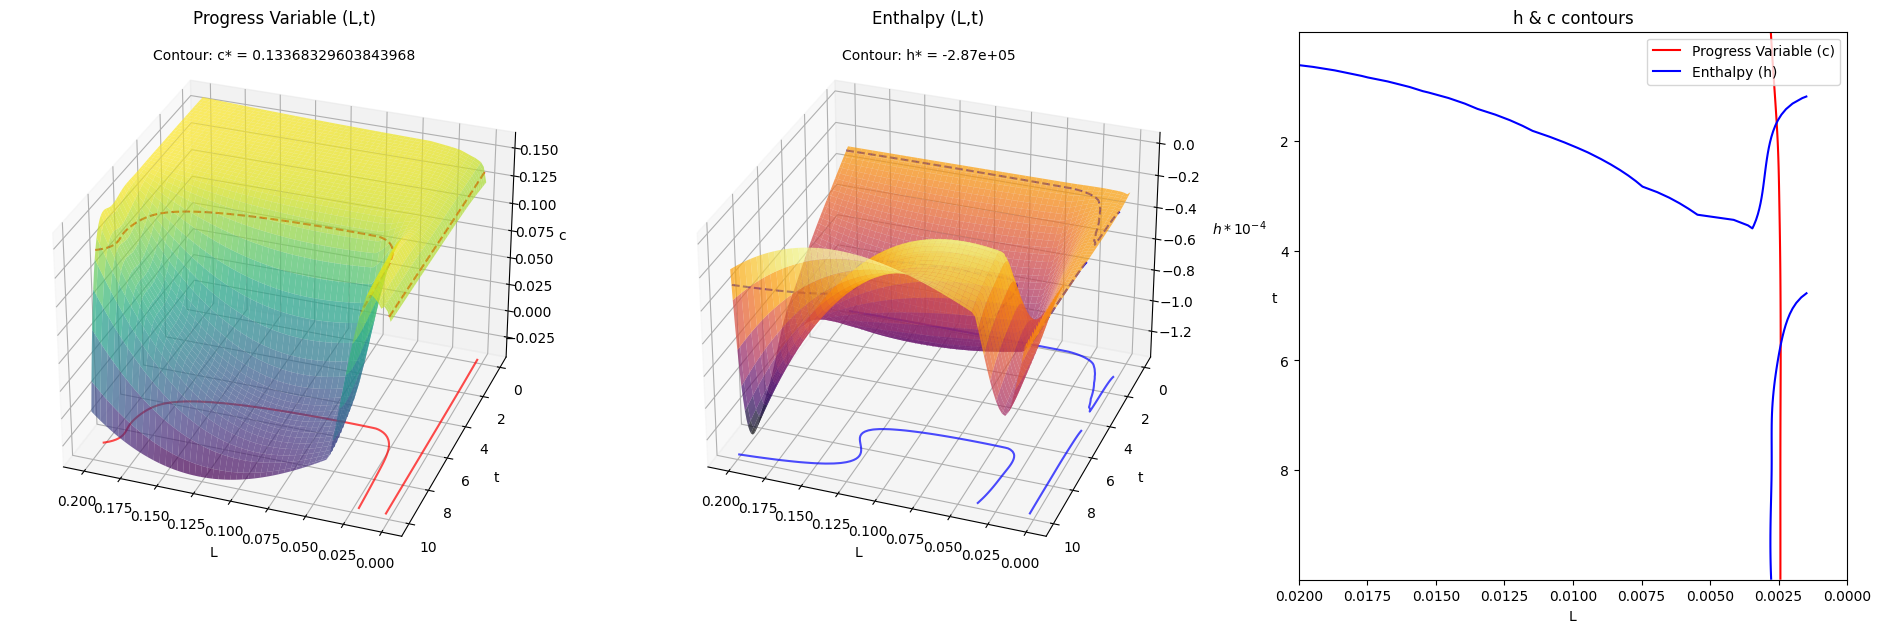

In [39]:
from matplotlib.lines import Line2D
Lbounds = [min(Lvals), max(Lvals)]
tbounds = [min(tvals), max(tvals)]

xim = 0.25
xiv = 0.25*xim*(1-xim)
cknown = 0.13368329603843968
hknown = -286731.75702770625 
print("c: ", cknown)
print("h: ", hknown)

#----- General Formatting
fig = plt.figure(figsize = (20,20))
ccol = 'r'
hcol = 'b'
alpha = 0.7 #transparency
#plt.rcParams.update({'font.size': 10})  #global font size update

#----- Plot Progress Variable
ax = fig.add_subplot(131, projection='3d')
ax.plot_surface(x,y,cs, cmap='viridis', alpha = alpha)

#Add contours
contour_lines = ax.contour(x, y, cs, zdir='z', levels=[cknown], colors=ccol, linestyles = 'dashed')
contour_bottom = ax.contour(x, y, cs, zdir='z', levels=[cknown], colors=ccol, offset = ax.get_zlim()[0], alpha = alpha, linestyles = 'solid')

#Formatting
ax.set_title("Progress Variable (L,t)")
ax.text2D(0.5, 0.95, f'Contour: c* = {cknown}', transform=ax.transAxes, ha='center')
ax.set_xlabel("L")
ax.set_ylabel("t")
ax.set_zlabel("c")
ax.view_init(30, 110)

#----- Plot Enthalpy
ax = fig.add_subplot(132, projection='3d')
ax.plot_surface(x,y,hs, cmap='inferno', alpha = alpha)

#Add contours
contour_lines = ax.contour(x, y, hs, zdir='z', levels=[hknown], colors=hcol, linestyles = 'dashed')
limits = ax.get_zlim()
contour_bottom = ax.contour(x, y, hs, zdir='z', levels=[hknown], colors=hcol, offset = ax.get_zlim()[0], alpha = alpha, linestyles = 'solid')

#Formatting
ax.set_title("Enthalpy (L,t)")
ax.text2D(0.5, 0.95, f'Contour: h* = {hknown:.2e}', transform=ax.transAxes, ha='center')
ax.set_xlabel("L")
#ax.set_xticks(np.arange(Lbounds[0], Lbounds[1], 0.04))
ax.set_ylabel("t")
ax.zaxis.set_rotate_label(False) 
ax.set_zlabel(r"$h*10^{-4}$", rotation = 0, labelpad = 20)
ax.view_init(30, 110)
ax.ticklabel_format(axis = 'z', style = 'scientific', useMathText = True)

#----- Plot Projections Only
ax = fig.add_subplot(133)

#Get projection data
cproj = ax.contour(x,y,cs, levels = [cknown], colors = ccol, linestyles = 'solid')
hproj = ax.contour(x,y,hs, levels = [hknown], colors = hcol, linestyles = 'solid')
#contour_aspect = (Lbounds[1]-Lbounds[0])/(tbounds[1]-tbounds[0])
#ax.set_aspect(contour_aspect)
ax.set_title("h & c contours")
ax.set_xlabel("L")
ax.set_xlim((0, 0.02))
contour_aspect = (0.02)/(tbounds[1]-tbounds[0])
ax.set_aspect(contour_aspect)
ax.set_ylabel("t", rotation = 0)
ax.invert_xaxis()
ax.invert_yaxis()
legend_elements = [
    Line2D([0], [0], color=ccol, label="Progress Variable (c)"),
    Line2D([0], [0], color=hcol, label="Enthalpy (h)")
]

#----- Add legend with the proxy artists
ax.legend(handles=legend_elements)

#----- Save and show final result
plt.tight_layout(pad = 5)
save = True
if save:
    plt.savefig(f'3DplotsANDcontour_c_{cknown:.5f}_h_{hknown:.2e}.png',bbox_inches='tight')  # Save as a PNG file
plt.show();

## Plot Temperature Snapshots: fixed xim, xiv
### Generate Data

In [99]:
ximT = 0.05
xivT = ximT*(1-ximT)/2 #1/2 of max variance
num_points = 100
Ls = np.linspace(min(Lvals)+1e-4, max(Lvals)-1e-4, num_points)
ts = np.linspace(min(tvals)+1e-4, max(tvals)-1e-4, num_points)

xT, yT = np.meshgrid(Ls, ts)
Ts = np.zeros_like(x)

for i in range(num_points):
    for j in range(num_points):
        Ts[i, j] = It(xim, xiv, xT[i, j], yT[i, j])

print('done')

done


### Plotting

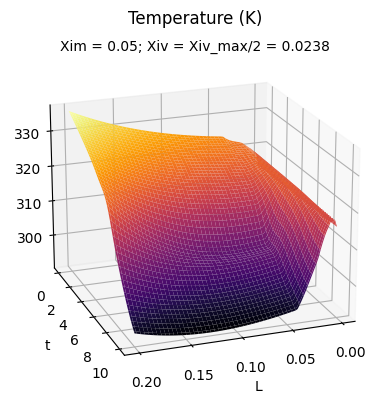

In [100]:
zdata = Ts
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=20, azim = 30)
ax.set_title("Temperature (K)")
ax.set_xlabel("L")
ax.set_ylabel("t")
ax.view_init(20, 70)
ax.set_zlim(bottom=np.min(zdata), top=np.max(zdata))
ax.plot_surface(xT, yT, zdata, cmap='inferno')
ax.text2D(0.5, 0.95, rf'Xim = {ximT:.2f}; Xiv = Xiv_max/2 = {xivT:.4f}', transform=ax.transAxes, ha='center')

plt.savefig(f'./figures/3DTemperature_xim_{ximT:.2f}_xiv_{xivT:.4f}.png',bbox_inches='tight')  # Save as a PNG file

### Animating

In [96]:
#Create Data
ximTarr = np.linspace(0.01, 0.99, 10)
xivTarr = ximTarr*(1-ximTarr)/2 #1/2 of max variance
num_points = 30
Ls = np.linspace(min(Lvals)+1e-4, max(Lvals)-1e-4, num_points)
ts = np.linspace(min(tvals)+1e-4, max(tvals)-1e-4, num_points)

xT, yT = np.meshgrid(Ls, ts)
Ts = np.zeros((len(ximTarr), len(Ls), len(ts)))

for k in range(len(ximTarr)):
    xim = ximTarr[k]
    xiv = xivTarr[k]
    print(k)
    for i in range(num_points):
        for j in range(num_points):
            Ts[k,i,j] = It(xim, xiv, xT[i, j], yT[i, j])

0
1
2
3
4
5
6
7
8
9


Current frame:  0
Current frame:  0
Current frame:  1
Current frame:  2
Current frame:  3
Current frame:  4
Current frame:  5
Current frame:  6
Current frame:  7
Current frame:  8
Current frame:  9
Current frame:  10
Current frame:  11
Current frame:  12
Current frame:  13
Current frame:  14
Current frame:  15
Current frame:  16
Current frame:  17
Current frame:  18
Current frame:  19
Current frame:  0


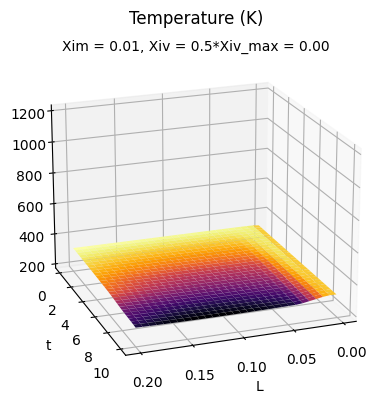

In [97]:
from matplotlib import animation

#Animate
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

animData = Ts
# Function to animate the plot
def animate(frame):
    print("Current frame: ", frame)
    if frame >= len(animData):
        frame = 2*len(animData)-1-frame
    ax.clear()  # Clear previous plot to update with new data
    ax.set_title("Temperature (K)")
    ax.set_xlabel("L")
    ax.set_ylabel("t")
    ax.view_init(20, 70)
    ax.set_zlim(bottom=np.min(animData), top=np.max(animData))
    surf = ax.plot_surface(xT, yT, animData[frame], cmap='inferno')
    ax.text2D(0.5, 0.95, f'Xim = {ximTarr[frame]:.2f}, Xiv = 0.5*Xiv_max = {xivTarr[frame]:.2f}', transform=ax.transAxes, ha='center')
    return surf,

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=2*len(animData), interval=200)

# Save the animation as a GIF
ani.save(f'Temperature_VariableXimXiv.gif', writer='pillow', fps=5)

## Plot Temperature Snapshots: fixed L, t
### Generate Data

In [133]:
LT = 0.04
tT = 1
num_points = 100
ximMax = 0.99
ximTs = np.linspace(0.01, ximMax, num_points)
xivTs = np.transpose(np.array([np.linspace(1e-4,xi*(1-xi)-1e-4, num_points) for xi in ximTs]))

#ximTmesh, xivTmesh = np.meshgrid(ximTs, np.hstack(xivTs))
ximTmesh, nichts = np.meshgrid(ximTs, np.linspace(0,1,num_points))
Ts = np.zeros_like(ximTmesh)

for i in range(num_points):
    if i%10 == 0:
        print(i)
    for j in range(num_points):
        Ts[i, j] = It(ximTmesh[i,j], xivTmesh[i,j], LT, tT)

0
10
20
30
40
50
60
70
80
90


## Animating

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# Function to animate the plot
def animate(frame):
    print("Current frame: ", frame)
    if frame >= len(zdata):
        frame = 2*len(zdata)-1-frame
    ax.clear()  # Clear previous plot to update with new data
    ax.view_init(elev=20, azim = 30)
    ax.set_title("Temperature")
    ax.set_xlabel("L")
    ax.set_ylabel("t")
    ax.set_zlabel("Temperature (K)")
    ax.set_zlim(bottom=np.min(zdata), top=np.max(zdata))
    surf = ax.plot_surface(x, y, zdata[frame], cmap='inferno')
    ax.text2D(0.5, 0.95, f'Xim = {xim[frame]:.2f}, Xiv = 0.5*Xiv_max = {xiv[frame]:.2f}', transform=ax.transAxes, ha='center')
    return surf,

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=2*len(zdata), interval=200)

# Save the animation as a GIF
ani.save(f'Enthalpy_VariableXimXiv.gif', writer='pillow', fps=5)

## Interactive Plots

In [10]:
#----- Interactive plots
def interact1(theta, phi, z):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x,y,z1, cmap='inferno')
    contour_lines = ax.contour(x, y, z1, zdir='z', levels=[z], colors='r')
    contour_bottom = ax.contour(x, y, z1, zdir='z', levels=[z], colors='r', offset = 0)
    ax.set_title("Enthalpy(L,t)")
    ax.set_xlabel("L")
    ax.set_ylabel("t")
    ax.set_zlabel("h")
    ax.view_init(theta, phi)
    plt.show();

def interact2(theta, phi, z):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x,y,z2, cmap='viridis')
    contour_lines = ax.contour(x, y, z2, zdir='z', levels=[z], colors='r')
    contour_bottom = ax.contour(x, y, z2, zdir='z', levels=[z], colors='r', offset = 0)
    ax.set_title("Progress Variable (L,t)")
    ax.set_xlabel("L")
    ax.set_ylabel("t")
    ax.set_zlabel("c")
    
    ax.view_init(theta, phi)
    plt.show();


#wgt.interact(interact1, theta=(0,90), phi=(0,360), z)
wgt.interact(interact2, theta=(0,90), phi=(0,360), z = np.arange(0.01, 0.13, 0.01))

interactive(children=(IntSlider(value=45, description='theta', max=90), IntSlider(value=180, description='phi'…

<function __main__.interact2(theta, phi, z)>

# Animate over values of $\xi_{mean}$
### WARNING: data  population may be incorrect. See method used above. 

In [20]:
#Create data
xim = np.linspace(0.01,0.99,20)
xiv = xim*(1-xim)/2 #Set xiv to be 1/2 of the maximum value for a given xim.
Ls = np.linspace(min(Lvals)+1e-3, max(Lvals)-1e-3, 50)
ts = np.linspace(min(tvals)+1e-3, max(tvals)-1e-3, 50)
hs = np.ones((len(xim), len(Ls), len(ts)))
cs = np.ones((len(xim), len(Ls), len(ts)))
for i in range(len(xim)):
    print(i)
    for l in range(len(Ls)):
        for t in range(len(ts)):
            hs[i,l,t] = Ih(xim[i], xiv[i], Ls[l], ts[t])
            cs[i,l,t] = Ic(xim[i], xiv[i], Ls[l], ts[t])

print("Checkpoint1")
x, y = np.meshgrid(Ls, ts)
z1 = hs
z2 = cs

0
1
2
3
4


/home/jaredwp91/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Checkpoint1


### h = h(t)

NameError: name 'animation' is not defined

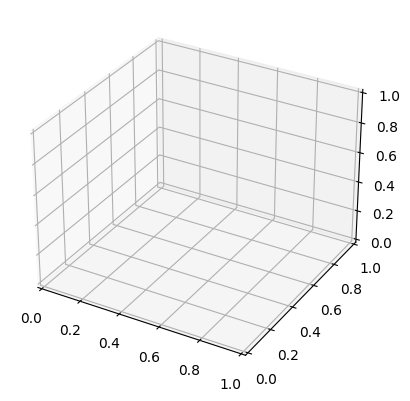

In [2]:
import matplotlib.animation as animation

# Animate the plot for enthalpy
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Function to animate the plot
def animate(frame):
    print("Current frame: ", frame)
    if frame >= len(z1):
        frame = 2*len(z1)-1-frame
    ax.clear()  # Clear previous plot to update with new data
    ax.view_init(elev=20, azim = 30)
    ax.set_title("Enthalpy(L,t)")
    ax.set_xlabel("L")
    ax.set_ylabel("t")
    ax.set_zlabel("h")
    ax.set_zlim(bottom=np.min(z1), top=np.max(z1))
    surf = ax.plot_surface(x, y, z1[frame], cmap='inferno')
    ax.text2D(0.5, 0.95, f'Xim = {xim[frame]:.2f}, Xiv = 0.5*Xiv_max = {xiv[frame]:.2f}', transform=ax.transAxes, ha='center')
    return surf,

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=2*len(z1), interval=200)

# Save the animation as a GIF
ani.save(f'Enthalpy_VariableXimXiv.gif', writer='pillow', fps=5)

### c = c(t)

Current frame:  0
Current frame:  0
Current frame:  1
Current frame:  2
Current frame:  3
Current frame:  4
Current frame:  5
Current frame:  6
Current frame:  7
Current frame:  8
Current frame:  9
Current frame:  10
Current frame:  11
Current frame:  12
Current frame:  13
Current frame:  14
Current frame:  15
Current frame:  16
Current frame:  17
Current frame:  18
Current frame:  19
Current frame:  20
Current frame:  21
Current frame:  22
Current frame:  23
Current frame:  24
Current frame:  25
Current frame:  26
Current frame:  27
Current frame:  28
Current frame:  29
Current frame:  30
Current frame:  31
Current frame:  32
Current frame:  33
Current frame:  34
Current frame:  35
Current frame:  36
Current frame:  37
Current frame:  38
Current frame:  39
Current frame:  0


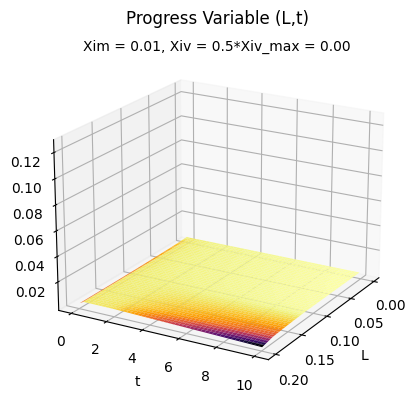

In [28]:
# Animate the plot for progress variable
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Function to animate the plot
def animate(frame):
    print("Current frame: ", frame)
    if frame >= len(z2):
        frame = 2*len(z2)-1-frame
    ax.clear()  # Clear previous plot to update with new data
    ax.view_init(elev=20, azim = 30)
    ax.set_title("Progress Variable (L,t)")
    ax.set_xlabel("L")
    ax.set_ylabel("t")
    ax.set_zlabel("c")
    ax.set_zlim(bottom=np.min(z2), top=np.max(z2))
    surf = ax.plot_surface(x, y, z2[frame], cmap='inferno')
    ax.text2D(0.5, 0.95, f'Xim = {xim[frame]:.2f}, Xiv = 0.5*Xiv_max = {xiv[frame]:.2f}', transform=ax.transAxes, ha='center')
    return surf,

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=2*len(z2), interval=200)

# Save the animation as a GIF
ani.save(f'ProgressVariable_VariableXimXiv.gif', writer='pillow', fps=5)

# Archive

## extractContour Function

In [ ]:
def extractContour(zval, data):
    """
    Extracts the contour line data for Z = z(x,y). 
    Inputs: 
        zval: contour's value of z
        data: tuple or array with 3 elements (in order):
            X: meshed array of x data points (2D
            Y: meshed array of y data points (2D)
                NOTE: xdata, ydata = np.meshgrid(xdata ydata)
            Z: array of z data points (2D)
    Outputs: 
        lines: numpy array of points [x,y,z] 
    Example usage: 
        >>> zval   = 0.10
        >>> X, Y   = np.meshgrid(xdata, ydata)
        >>> data   = (X, Y, zdata)
        >>> points = extractContour(zval, data)
        >>> fig    = plt.figure()
        >>> ax     = fig.add_subplot(111, projection='3d')
        >>> ax.scatter(points[:,0], points[:,1], points[:,2])
    """
    xdat, ydat, zdat = data
    X, Y = np.meshgrid(xdat, ydat)
    contour_lines = plt.contour(xdat, ydat, zdat, levels = (zval,))

    # Find intersection points of contour lines with the plane
    lines = []
    for line_collection in contour_lines.collections:
        for path in line_collection.get_paths():
            vertices = path.vertices
            for point in vertices:
                xpt, ypt = point
                lines.append([xpt, ypt, zval])

    plt.close()
    return np.array(lines)

## Making a Jacobian calculator
This code is now implemented in tm2. This was coded outside of the main code so that I could benchmark it against sympy's existing jacobian calculator. Result: manually-coded solution is ~10x faster

In [ ]:
def getJac(F, X):
    """Computes the 2x2 Jacobian of F(X) at X
    NOTE: This function assumes constant xim and xiv. These parameters are included in F and X
            to allow a generic function to be used.
    Params:
        F: f(mvlt) = [h(mvlt), c(mvlt)]
            def F(mvlt):
                return np.array([hInterp(*mvlt), cInterp(*mvlt)])
        X: [xim, xiv L, t]
    Returns:
        J: [[dH/dL  dH/dt],
            [dc/dL  dc/dt]]
    """
    # Confirm X is an array
    X = np.array(X)

    # Get initial point
    F0 = F(X)

    # Set deltas
    eps = 1e-16 # machine precision
    scalar = np.sqrt(eps)
    deltaL = np.array([0, 0, X[2]*scalar, 0])
    deltat = np.array([0, 0, 0, X[3]*scalar])
    
    # Compute gradients
    J0 = (F(X + deltaL)-F0)/deltaL[2]  # = [dH/dL, dc/dL]
    J1 = (F(X + deltat)-F0)/deltat[3]  # = [dH/dt, dc/dt]

    return np.array([J0, J1]).T

def hInterp(xim, xiv, L, t):
    return xim**2+ xiv**(-2) + L**3 + 2*t

def cInterp(xim, xiv, L, t):
    return xim**(-3) + xiv + L**2 - 0.4*t

def F(mvlt):
    return np.array([hInterp(*mvlt), cInterp(*mvlt)])

# Manually-coded solution
X = [100, 0.2, 0.05, 0.2]

import timeit
times = []
for i in range(1000):
    start = timeit.timeit()
    getJac(F, X)
    end = timeit.timeit()
    times.append(end - start)
print(getJac(F, X))
print(f"Average time = {np.mean(times):.2e} s")

[[ 0.00727596  1.99997885]
 [ 0.10000001 -0.4       ]]
Average time = -1.77e-04 s


Result: manual-coded is faster by ~ 10x

In [ ]:
arr1 = np.array([0, 0, 2 ,3 ])
arr2 = np.array([0.1, 0.1, 0.1, 0.1])
(arr1<arr2).all()

False

## Compare tableMaker and tm2
When this was made, the only major difference was that tm2 interpolated using normalized values of $\sigma^2$, whereas tableMaker interpolated in the variance coordinate directly.

In [40]:
import codes.TableMakerMain.postGit.Archive.tableMaker as tableMaker
import tableMakerv2 as tM2
#----- Create T Table
phi = 'T'
table, indices = tableMaker.makeLookupTable(path, Lvals, tvals, phi,
                                    numXim = 5, numXiv = 5, get_data_files_output = data_output)
table2, indices2 = tM2.makeLookupTable(path, Lvals, tvals, phi, 
                                       numXim =5, numXiv = 5, get_data_files_output = data_output)

# Testing the new code 
It1 = tableMaker.createInterpolator(table, indices)
It2 = tM2.createInterpolator(table2, indices2)

# This is a point on the grid.
xim = 0.5
xiv = 0.125
L = 0.02
t = 2
# When using a grid point, the values line up almost exactly.
print(It1(xim, xiv, L, t))
print(It2(xim, xiv, L, t))

# This isn't a point on the grid:
xim = 0.4
xiv = xim*(1-xim)*0.3
L = 0.02
t = 2
# When using a non-grid point, the two can differ greatly.
print(It1(xim, xiv, L, t))
print(It2(xim, xiv, L, t))

1043.3231273496444
1043.3231260830655
1306.4790377923755
1337.6920124389962


## Contour Plot Demo
Demonstration of matplotlib's default ability to find specific contours (used in creating visual representations of the (h,c) -> (L,t) solve)

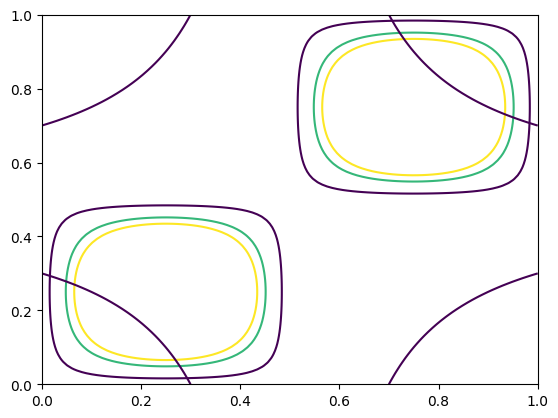

In [185]:
x = np.linspace(0,1,100)
y = np.linspace(0,1,100)
X,Y = np.meshgrid(x,y)

Z = np.sin(2*np.pi*X)*np.sin(2*np.pi*Y)
W = (X-0.5)**2 * (Y-0.5)**2

plt.contour(X,Y,Z, levels = [0.1,0.3,0.4])
plt.contour(X,Y,W, levels = [0.01]);

## Rotating Plot Animation
Note: some kind of x, y, and z data is needed for this code to work.

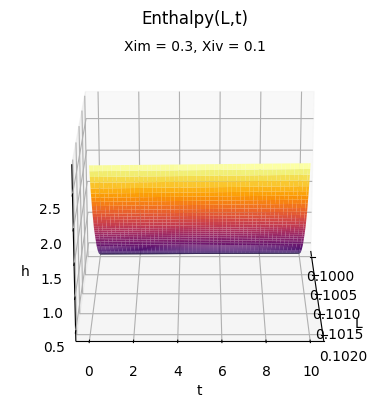

In [12]:
from matplotlib import animation

#----- Animate the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Function to animate the plot
def animate(frame):
    ax.clear()  # Clear previous plot to update with new data
    ax.view_init(elev=20, azim=4*frame)
    ax.set_title("Enthalpy(L,t)")
    ax.set_xlabel("L")
    ax.set_ylabel("t")
    ax.set_zlabel("h")
    surf = ax.plot_surface(x, y, z1, cmap='inferno')
    ax.text2D(0.5, 0.95, f'Xim = {xim}, Xiv = {xiv}', transform=ax.transAxes, ha='center')
    return surf,

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=90, interval=200)

# Save the animation as a GIF
ani.save(f'Enthalpy_xim{xim}_xiv{xiv}.gif', writer='pillow', fps=15)

## Regex Testing

In [ ]:
#Testing Grounds

#Array masking
a = np.ones(10)*(-1)
for i in range(len(a)-1):
    a[i] = np.random.rand()
aNew = a[a!=-1]

#Regex
pattern = r"L_([\d.]+)[SU]_([\d.]+)\.dat"
candidates = ["L_0.03U_198.dat", "L_0.002S_299.dat", "L0990U900.dat"]
for c in candidates:
    print(search(pattern, c))

L = 0.03
pattern2 =  f"L_{L}[SU]_[\d]*\.dat"
arr2 = ["L_0.02S_001.dat", "L_0.02S_003.dat", "L_0.02S_002.dat", "L_0.02U_001.dat", "L_0.03S_001.dat"]
print("Here", len([name for name in arr2 if match(pattern2, name)]))
arr = [0.1, 0.4, 0.5, 0.2, 0.7, 0.15]
print(np.sort(arr)[::-1])

## $\beta$-PDF Endpoint Behavior Testing

In [ ]:
# Fidelity Test: trying to determine the behavior of the BetaPDF near 0 and 1
import LiuInt as LI
from tm2 import phiFuncs
function = phiFuncs("../flame/run", 'T', fileName = 'L_0.002U_24.dat')

#For what value of xim is xim = 0 = x a good approximation? 
#Hypothesis: Something beneath 1e-6 will work fine. 
Min = -1
xim = np.logspace(0, Min,10)
xiv = np.logspace(0, Min,10)
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
  
# Creating 2-D grid of features 
[X, Y] = np.meshgrid(xim, xiv) 
  
fig, ax = plt.subplots(1, 1) 

Z = np.zeros((len(xim), len(xiv)))
for i in range(len(xim)):
    for j in range(len(xiv)):
        Z[i,j] = LI.IntegrateForPhiBar(xim[i], xiv[j], function)

# plots filled contour plot 
ax.contourf(X, Y, Z) 
  
ax.set_title('Predicted values') 
ax.set_xlabel('Xim') 
ax.set_xscale('log')
ax.set_ylabel('Xiv')
ax.set_yscale('log')
cs = ax.contourf(X, Y, Z, locator=ticker.LogLocator(), cmap=cm.PuBu_r)
cbar = fig.colorbar(cs)
  
plt.show() 
plt.savefig('Fidelity_min.png', dpi=300, bbox_inches='tight')